In [3]:
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')


### Makesure that your runtime is using GPU

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Connect with your Google Drive to download dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Unzip dataset

In [ ]:
!unzip "/content/drive/My Drive/Sharing_storage1/dataset_license.zip"

### Data agumentation

In [0]:
import cv2
import numpy as np
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img
%matplotlib inline

In [0]:
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              rescale=1/255,
                              fill_mode="nearest",
                              validation_split=0.1) # set validation split

print(image_gen.flow_from_directory("dataset_license/"))

Found 37623 images belonging to 36 classes.


### Create model following Nidia model architecture

In [0]:
import tensorflow as tf
import keras
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, AveragePooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [0]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(224, 80, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu'))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
      
    # output layer:
    model.add(Dense(512, activation='elu'))  # not in original model. added for more robustness
    model.add(Dense(36,activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 110, 38, 24)       1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 53, 17, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 7, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 23, 5, 64)         27712     
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 5, 64)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 3, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 4032)             

In [0]:
checkpoint_filepath = 'License_plate_nvidia.h5'
# EarlyStopping allows model to stop traning in case loss is not reduced after 5 epochs 
# ModelCheckpoint allosw model to save weight everytime loss is reduced
my_checkpointer = [
                   EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                   ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)
                   ]

### Define train and valid dataset and intergated it with data augumentation techinque

In [0]:
input_shape = (224,80,3)
batch_size = 64

train_image_gen = image_gen.flow_from_directory("dataset_license",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical",
                                                subset="training")
valid_image_gen = image_gen.flow_from_directory("dataset_license",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical",
                                                subset="validation")

Found 33877 images belonging to 36 classes.
Found 3746 images belonging to 36 classes.


### Train Model

In [0]:
#model.load_weights("License_plate_nvidia.h5")
result = model.fit_generator(train_image_gen,epochs=40,steps_per_epoch=len(train_image_gen),
                           validation_data=valid_image_gen,validation_steps=len(valid_image_gen),callbacks=my_checkpointer,verbose=1)

Epoch 1/40
530/530 [==============================] - 142s 268ms/step - loss: 1.9822 - acc: 0.4069 - val_loss: 1.7922 - val_acc: 0.5494

Epoch 00001: val_loss improved from inf to 1.79222, saving model to License_plate_nvidia.h5
Epoch 2/40
530/530 [==============================] - 139s 262ms/step - loss: 0.8825 - acc: 0.7336 - val_loss: 1.3159 - val_acc: 0.6543

Epoch 00002: val_loss improved from 1.79222 to 1.31586, saving model to License_plate_nvidia.h5
Epoch 3/40
530/530 [==============================] - 138s 260ms/step - loss: 0.6329 - acc: 0.8100 - val_loss: 1.2151 - val_acc: 0.7026

Epoch 00003: val_loss improved from 1.31586 to 1.21513, saving model to License_plate_nvidia.h5
Epoch 4/40
530/530 [==============================] - 139s 262ms/step - loss: 0.5493 - acc: 0.8351 - val_loss: 1.0012 - val_acc: 0.7344

Epoch 00004: val_loss improved from 1.21513 to 1.00122, saving model to License_plate_nvidia.h5
Epoch 5/40
530/530 [==============================] - 138s 260ms/step - 

### Ploting result

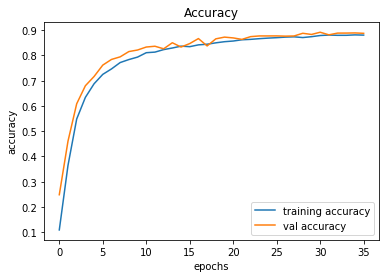

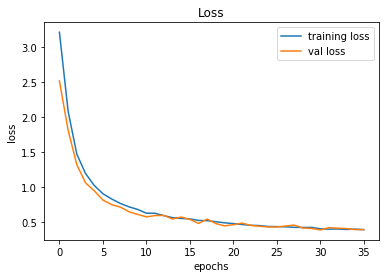

In [0]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
#plt.savefig("Accuracy.png", dpi=300)

plt.figure(1)
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig("Loss.png", dpi=300)

### Save model architecture as json file

In [0]:
from keras.models import model_from_json
model_json = model.to_json()
with open("License_plate_nvidia.json","w") as json_file:
  json_file.write(model_json)

### Try to reduce learning rate to improve the model quality

In [0]:
adam = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
result2 = model.fit_generator(train_image_gen,epochs=40,steps_per_epoch=len(train_image_gen),
                           validation_data=valid_image_gen,validation_steps=len(valid_image_gen),callbacks=my_checkpointer,verbose=1)

Epoch 1/40
530/530 [==============================] - 141s 267ms/step - loss: 0.3091 - acc: 0.9071 - val_loss: 0.8700 - val_acc: 0.8062

Epoch 00001: val_loss improved from 1.00122 to 0.86997, saving model to License_plate_nvidia.h5
Epoch 2/40
530/530 [==============================] - 139s 262ms/step - loss: 0.2707 - acc: 0.9173 - val_loss: 0.8323 - val_acc: 0.8065

Epoch 00002: val_loss improved from 0.86997 to 0.83227, saving model to License_plate_nvidia.h5
Epoch 3/40
530/530 [==============================] - 139s 263ms/step - loss: 0.2585 - acc: 0.9219 - val_loss: 0.8324 - val_acc: 0.8011

Epoch 00003: val_loss did not improve from 0.83227
Epoch 4/40
530/530 [==============================] - 139s 262ms/step - loss: 0.2488 - acc: 0.9236 - val_loss: 0.8224 - val_acc: 0.8022

Epoch 00004: val_loss improved from 0.83227 to 0.82241, saving model to License_plate_nvidia.h5
Epoch 5/40
530/530 [==============================] - 139s 261ms/step - loss: 0.2466 - acc: 0.9258 - val_loss: 0.

# The End!